In [1]:
from datetime import datetime
from glob import glob
import json
import os

import cv2
from keras import losses, Model, optimizers, metrics
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, DepthwiseConv2D, Dropout, Flatten, Input, Reshape
from keras.losses import SparseCategoricalCrossentropy
# from keras.metrics import MeanSquaredError, SparseCategoricalAccuracy
from keras.utils import losses_utils, plot_model
from livelossplot import PlotLossesKeras, PlotLossesKerasTF
from matplotlib import pyplot as plt
from numpy import interp
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.python.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.python.ops.image_ops_impl import *

from FUNCTIONS.dataset_mkr import *
from FUNCTIONS.eval_function import *
from FUNCTIONS.gpu_memory import *
from FUNCTIONS.model_visualizer import *

2022-11-10 13:28:24.920806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 13:28:25.052748: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 13:28:25.635506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/z/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-10 13:28:25.635572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [2]:
# load tensorboard
%load_ext tensorboard


In [3]:
"""
0 CPU
1 필요한 만큼 메모리를 런타임에 할당
2 GPU에 할당되는 전체 메모리 크기를 제한
"""
set_gpu_memory(1)

1 Physical GPUs, 1 Logical GPUs


2022-11-10 13:28:26.738006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:28:26.742422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:28:26.742667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:28:26.743219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
MIN, MAX = 0, 255
CLASS = 23
CLASS += 1  ## BG CLASS
print(CLASS)

24


# 1. DATASET

In [5]:
data_path = f"/media/z/0/MVPC10/DATA/03_PROCESSED"
label_path = f"/media/z/0/MVPC10/CODE/DL_base/OUT/LABEL/PIXEL_LABEL"

file = f"/media/z/0/MVPC10/DATA/LABEL/v2.2_none_zero.csv"
df = pd.read_csv(file)
df = df.iloc[:,0]
print(df)


0        1650317836858
1        1650317896295
2        1650319276179
3        1650319336444
4        1650319516913
             ...      
32990    1661953936322
32991    1661953996801
32992    1661954056432
32993    1661954116964
32994    1661954296445
Name: path, Length: 32995, dtype: int64


In [6]:
def df_to_tensor(df, path0, path1):
    data = []
    label = []
    # data = np.empty([80, 80], dtype=np.float32)
    # label = np.empty([80, 80], dtype=np.float32)
    for i in range(len(df)):
        try:
            data_img = Image.open(f"{path0}/{df.iloc[i]}.png")
            label_img = Image.open(f"{path1}/{df.iloc[i]}.png")
            data.append(list(data_img.getdata()))
            label.append(list(label_img.getdata()))

            # data_img = cv2.imread(f"{path0}/{df.iloc[i]}.png", 0)
            # label_img = cv2.imread(f"{path1}/{df.iloc[i]}.png", 0)
            # data = np.concatenate((data, data_img), axis=0, dtype=np.float32)
            # label = np.concatenate((label, label_img), axis=0, dtype=np.float32)
        except Exception as E:
            print(E)
            pass
        if i%10000 == 0:  print(i)
    return data, label

data_li, label_li = df_to_tensor(df, data_path, label_path)


0
10000
20000
30000


In [7]:
data = np.array(data_li, dtype=np.float32)
data = data.reshape(data.shape[0], 80, 80, 1)
print(data.shape)

label = np.array(label_li, dtype=np.float32)
label = label.reshape(label.shape[0], 80, 80, 1)
print(label.shape)

H, W = data.shape[1], data.shape[2]
print(H, W)


(32995, 80, 80, 1)
(32995, 80, 80, 1)
80 80


In [8]:
label.dtype


dtype('float32')

### 1.5 PROCESS

In [9]:
## ---------------------------------------------------------------- SHUFFLE
# seed = 99
# np.random.seed(seed)
# np.random.shuffle(data)
# # np.random.seed(seed)
# np.random.shuffle(label)

## ---------------------------------------------------------------- LABEL NORMALIZE
norm_label = label  ## NO NORMALIZE

## ---------------------------------------------------------------- DATA NORMALIZE
# print(data[0][0])
norm_data = data/MAX
# print(norm_data[0][0])

## ---------------------------------------------------------------- SPLIT
split1 = int(len(label)*0.96)
X1, X2 = norm_data[:split1], norm_data[split1:]
Y1, Y2 = norm_label[:split1], norm_label[split1:]
## ---------------------------------------------------------------- VAL SPLIT
# split2 = int(len(label)*0.9)
# X1, val_data = X1[:split2], X1[split2:]
# X2, val_label = X2[:split2], X2[split2:]



In [10]:
print(X1.shape)
print(Y1.shape)
print(X2.shape)
print(Y2.shape)

(31675, 80, 80, 1)
(31675, 80, 80, 1)
(1320, 80, 80, 1)
(1320, 80, 80, 1)


# 2. TRAIN

In [11]:
from FUNCTIONS.model import *

LOAD_MODEL = 1
MODEL_VERSION = f"v2.3"

if LOAD_MODEL == 0:
    ## ---------------------------------------------------------------- SETUP
    inc = make_inc()
    # size = input_shape - layer_shape + 1
    ## con(filter, (size), stride, padding, activation, name, input)

    ## ---------------------------------------------------------------- IN
    # input = Input(shape=(H, W, 1))

    ## ---------------------------------------------------------------- HEAD
    # x = res(f'{inc()}', input, 64, 3, 1, 'valid', 'elu', 0.25)

    # model = unet((80, 80, 1))
    model = res_unet(32, 6, CLASS, (80, 80, 1))

    ## ---------------------------------------------------------------- BODY
    # x = res(f'{inc()}', x, 64, 3, 1, 'valid', 'elu', 0.25)
    # x = res(f'{inc()}', x, 64, 3, 1, 'valid', 'elu', 0.25)
    # x = res(f'{inc()}', x, 64, 3, 1, 'valid', 'elu', 0.25)
    # x = res(f'{inc()}', x, 64, 3, 1, 'valid', 'elu', 0.25)
    # x = res(f'{inc()}', x, 64, 3, 1, 'valid', 'elu', 0.25)
    # x = res(f'{inc()}', x, 64, 3, 1, 'valid', 'elu', 0.25)
    # x = res(f'{inc()}', x, 64, 3, 1, 'valid', 'elu', 0.25)

    ## ---------------------------------------------------------------- TAIL
    # x = Conv2D(1, 15, strides=2, name=f'{inc()}')(x)
    # x = tf.reduce_mean(x, (1, 2))  #, axis=None, keepdims=False, name=None)
    # x = Dropout(.5)(x)

    ## ---------------------------------------------------------------- OUT
    # output = Conv2D(1, x.shape[1], strides=4, name=f'{inc()}')(x)

    # model = Model(input, output)

    ## ---------------------------------------------------------------- OPTIMIZER
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #         initial_learning_rate=0.001,
    #         decay_steps=100000,
    #         decay_rate=0.96,
    #         staircase=True)

    # lr_schedule = k.optimizers.schedules.CosineDecay(initial_learning_rate=1e-4,
    #                                                  decay_steps=EPOCH,
    #                                                  )

    # optimizer = optimizers.Adam(learning_rate=lr_schedule)
    optimizer = optimizers.Adam(learning_rate=0.0001)

    ## ---------------------------------------------------------------- LOSS
    # def adaptive_loss():
    #     pass
    # loss = losses.MeanAbsoluteError()
    # loss = losses.BinaryCrossentropy()
    # loss = losses.MeanSquaredError()
    # loss = losses.SparseCategoricalCrossentropy()
    loss = losses.BinaryFocalCrossentropy(gamma=2.0,
                                          # from_logits=False,
                                          # apply_class_balancing=False,
                                          # alpha=0.25,
                                          # label_smoothing=0.0,
                                          # axis=-1,
                                          # reduction=losses_utils.ReductionV2.AUTO,
                                          # name='binary_focal_crossentropy'
                                          )

    ## ---------------------------------------------------------------- METRICS
    metrics = ['accuracy']
    # metrics = [SparseCategoricalAccuracy]
    # metrics = [metrics.MeanSquaredError()]

    ## ---------------------------------------------------------------- COMPILE
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


elif LOAD_MODEL == 1:
    # model_path = f"OUT/{MODEL_VERSION}/model/20221024-191637.h5"
    model_path_last = glob(f"OUT/{MODEL_VERSION}/model/*.h5")[-1]
    model = tf.keras.models.load_model(model_path_last)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d_48 (Conv2D)             (None, 80, 80, 64)   640         ['input_3[0][0]']                
                                                                                                  
 conv2d_49 (Conv2D)             (None, 80, 80, 64)   36928       ['conv2d_48[0][0]']              
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 40, 40, 64)  0           ['conv2d_49[0][0]']              
                                                                                            

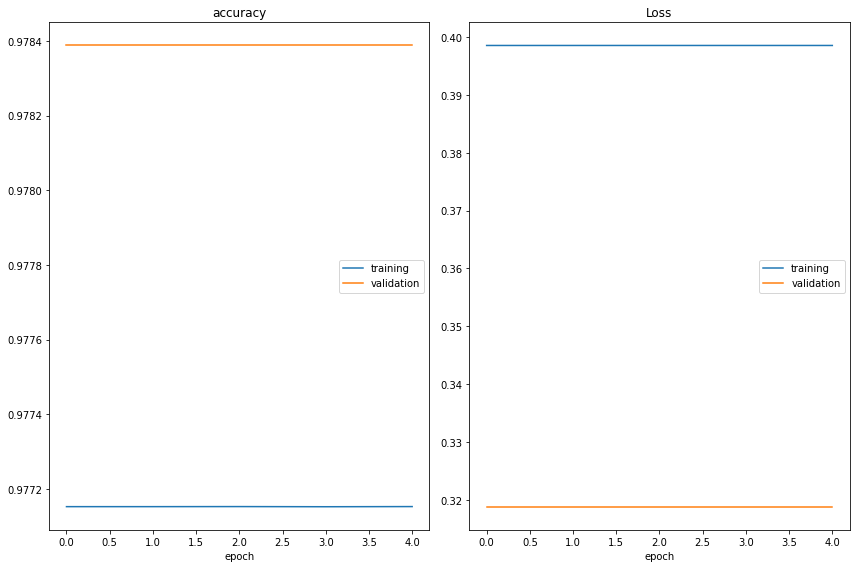

accuracy
	training         	 (min:    0.977, max:    0.977, cur:    0.977)
	validation       	 (min:    0.978, max:    0.978, cur:    0.978)
Loss
	training         	 (min:    0.399, max:    0.399, cur:    0.399)
	validation       	 (min:    0.319, max:    0.319, cur:    0.319)
891/891 [==============================] - 96s 108ms/step - loss: 0.3985 - accuracy: 0.9772 - val_loss: 0.3188 - val_accuracy: 0.9784
Epoch 00005: early stopping


In [12]:
EPOCH = 16
BATCH = 32
# ES = 16
ES = EPOCH//4

## fit
log_path = f"OUT/{MODEL_VERSION}/logs/"+datetime.now().strftime("%Y%m%d-%H%M%S")
es = EarlyStopping(monitor="val_loss", patience=ES, verbose=2, mode='auto')
tensorboard_callback = TensorBoard(log_dir=log_path, histogram_freq=1)

history = model.fit(X1, Y1,
                    validation_split=0.1,
                    # validation_data=(val_data, val_label),
                    batch_size=BATCH,
                    epochs=EPOCH,
                    use_multiprocessing=True,
                    verbose=1,
                    callbacks=[es,
                               tensorboard_callback,
                               PlotLossesKeras(),
                               # PlotLossesKerasTF(),
                               ],
                    )

# 3. EVALUATE

In [13]:
# conv_layers1 = []
# for i in model.layers:
#     if 'C2' in i.output:
#         print()
#         # conv_layers1.append(i.output)
# conv_layers1
#

In [14]:
# a = model.get_layer('8_C2').output
# a

In [15]:
# conv_layer_index = [1, 5, 9, 13]
# conv_layers = [model.layers[i].output for i in conv_layer_index]
# # conv_layers = [i.output for i in model.layers if "C2" in i.name][:1]
# print(conv_layers)

In [16]:
# visualize_model = Model(model.inputs, conv_layers)
# print(visualize_model.summary())

In [17]:
# for i in range(20, 100, 10):
#     img = X2[i]
#     re_img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
#     conv_img = visualize_model.predict(re_img)
#     # columns = int(round(np.sqrt(model.shape[1])))
#     # rows = int(round(np.sqrt(model.shape[2])))
#     columns = 8
#     rows = 8
#     for c_img in conv_img:
#         # pos = 1
#         fig = plt.figure(figsize=(12, 12))
#         for i in range(1, columns*rows+1):
#             fig = plt.subplot(rows, columns, i)
#             fig.axis('off')
#             plt.imshow(c_img[:, :, i-1], cmap='gray')
#             # pos += 1
#         plt.show()

In [18]:
# filter_visualizer(model, data[0])

In [19]:
# # visual_keras(model, MODEL_VERSION)
# model_visualizer(model, data[0])

In [20]:
SAVE_MODEL = 0

if SAVE_MODEL == 1:
    model_save_name = f"OUT/{MODEL_VERSION}/model/{datetime.now().strftime('%Y%m%d-%H%M%S')}.h5"
    model.save(model_save_name)

In [21]:
# # TENSORBOARD == 1
# # if TENSORBOARD == 1:
# #     launch tensorboard @ localhost:6006
# #     %tensorboard --logdir logs/--host localhost --port 6006
# # %tensorboard --logdir={log_path}

In [22]:
# ## history to DF
# hdf = pd.DataFrame(history.history)
# hdf.keys()
#
# ## plot history
# hdf.plot(figsize=(9, 6), grid=1, xlabel="epoch", label="accuracy")
# plt.ylim([0, 2])
# plt.show()
#

In [23]:
# SAVE_MODEL_PLOT = 0
# if SAVE_MODEL_PLOT == 1:
#     plot_model(model, to_file=f"OUT/{MODEL_VERSION}/plot/{MODEL_VERSION}_modelplot.png", show_shapes=True, show_layer_names=False, show_layer_activations=True)


In [24]:
loss, acc = model.evaluate(X2, Y2, verbose=1)

predict = model.predict(X2)


42/42 [==============================] - 1s 32ms/step


In [25]:
## ---------------------------------------------------------------- OUPUT CONVERT
predict_0 = np.reshape(predict, (predict.shape[0], predict.shape[1], predict.shape[2], 1))
Y2_0 = np.reshape(Y2, (Y2.shape[0], Y2.shape[1], Y2.shape[2], 1))
print(predict_0.shape)
print(Y2_0.shape)

(1320, 80, 80, 1)
(1320, 80, 80, 1)


1


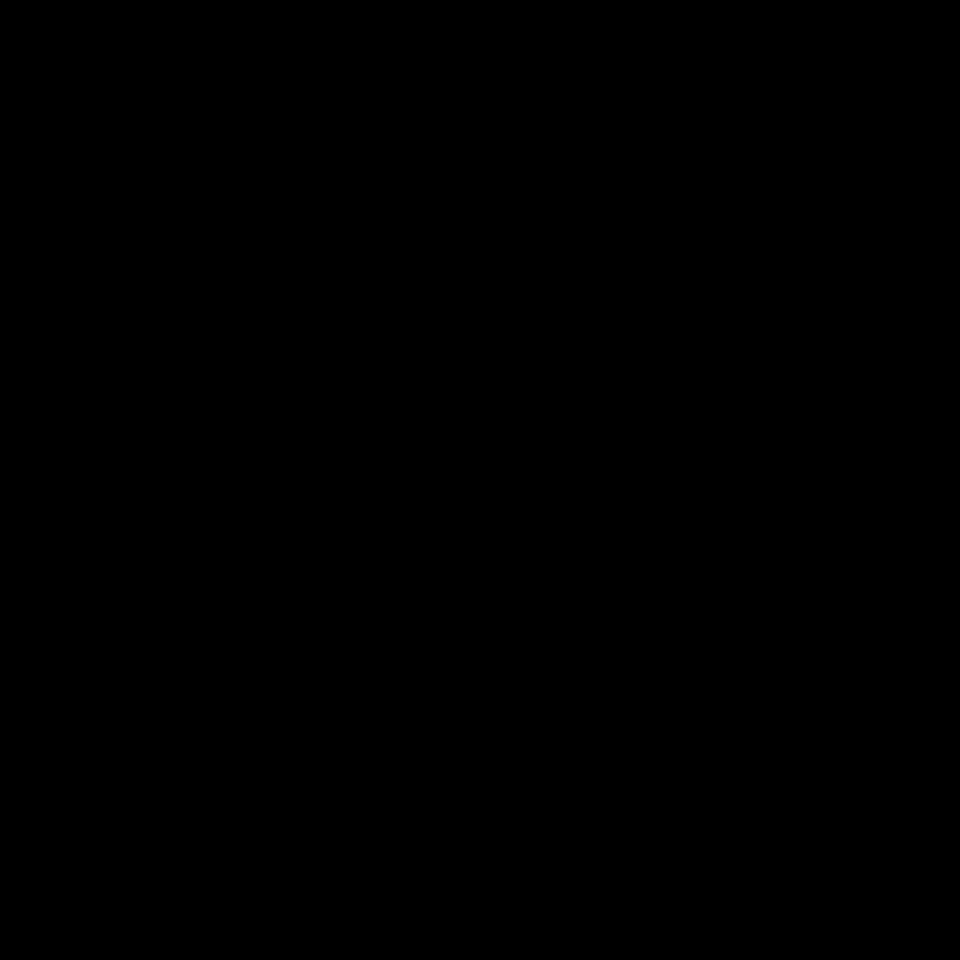

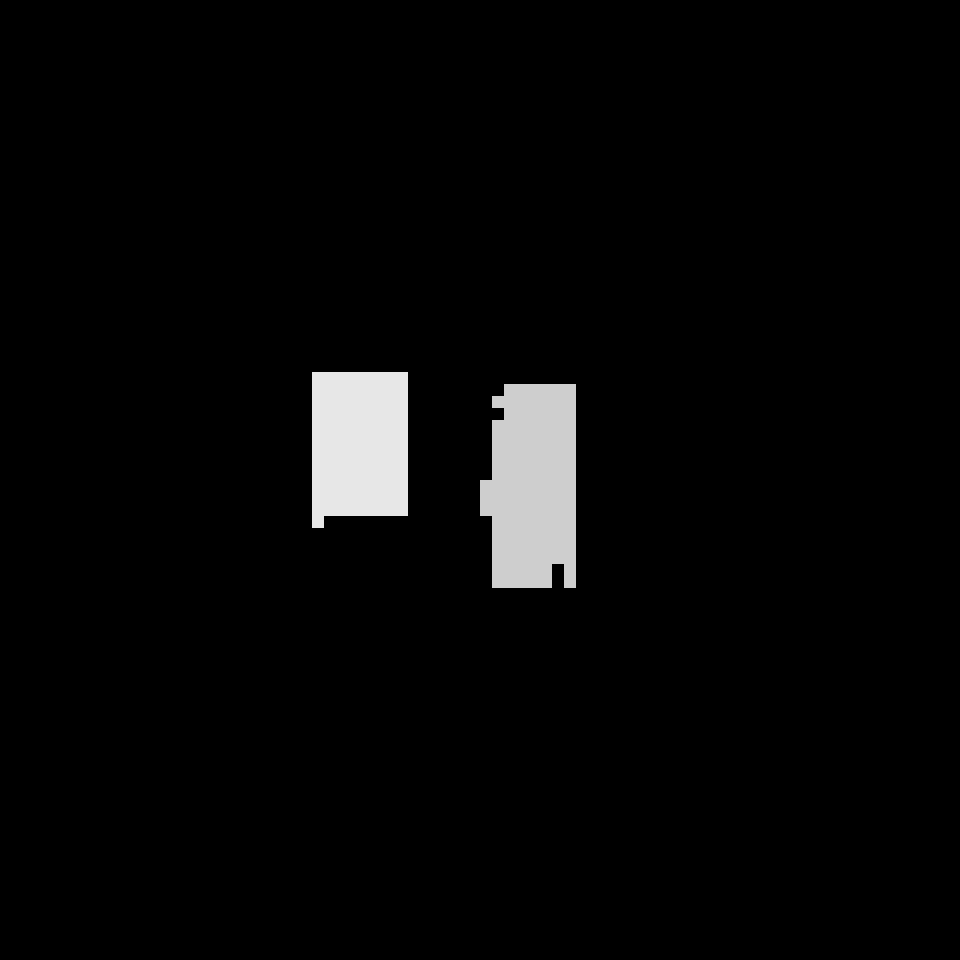

2


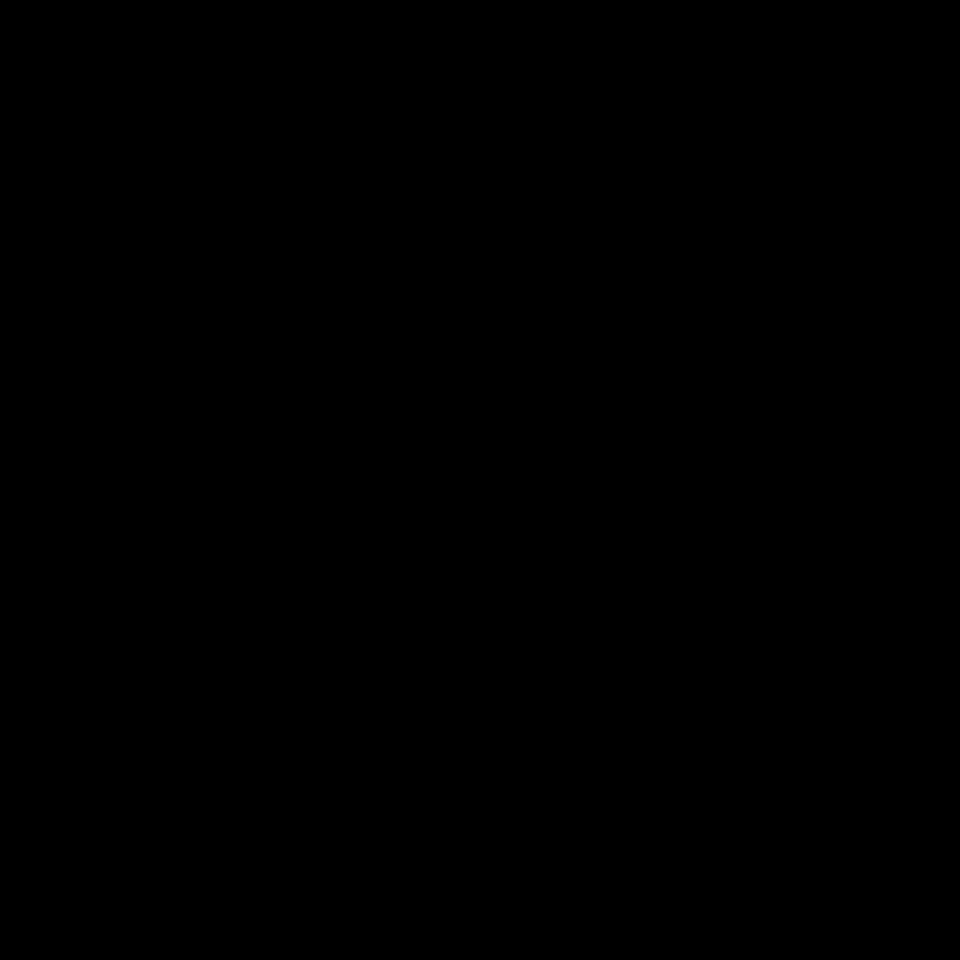

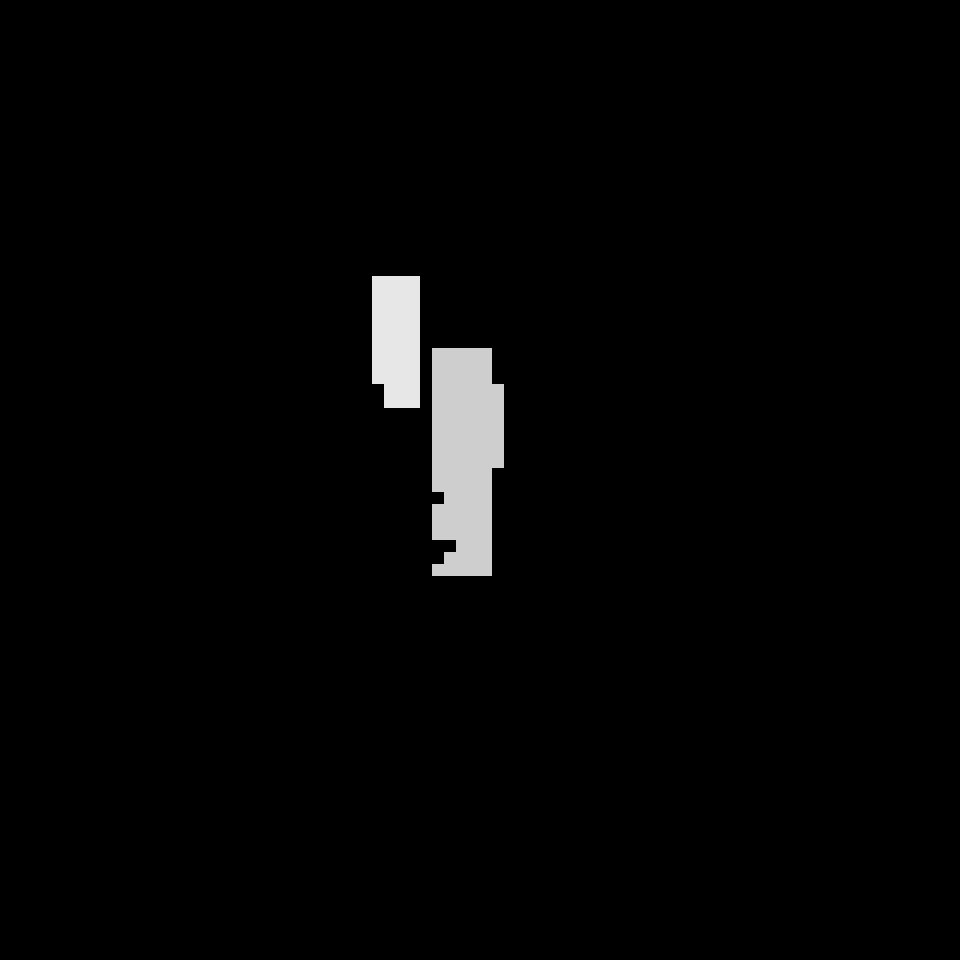

3


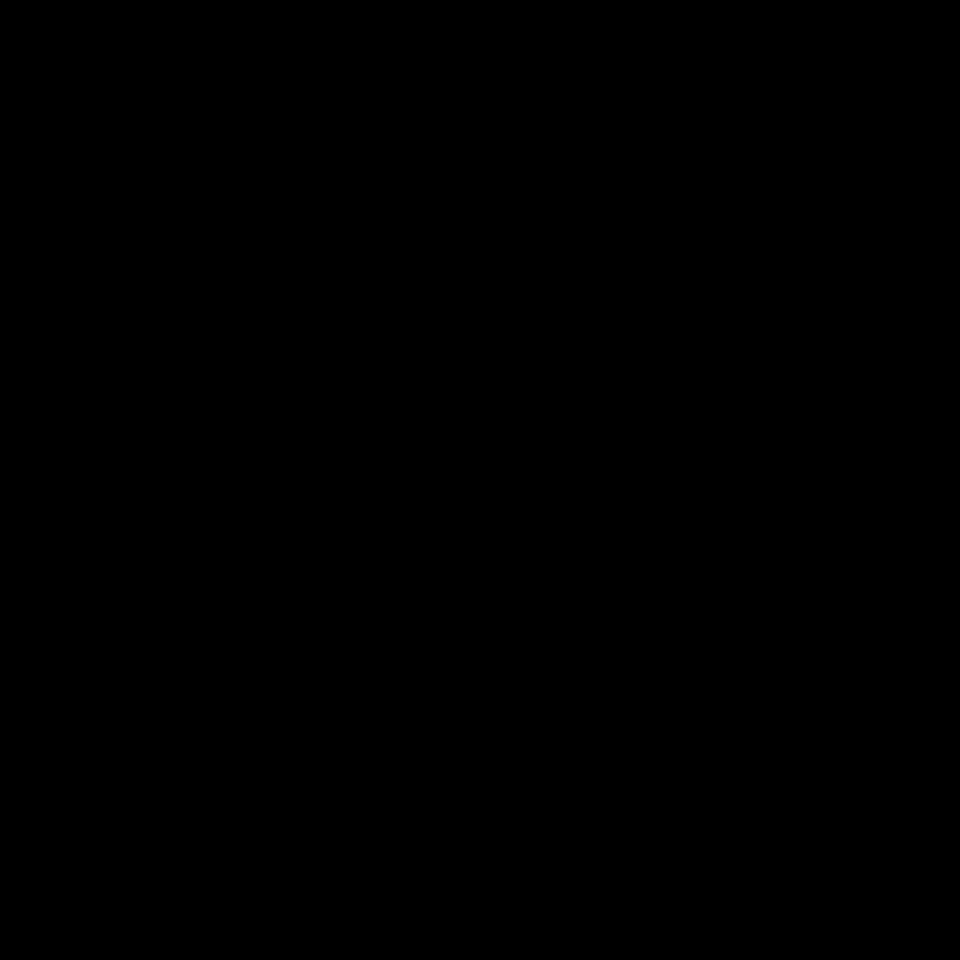

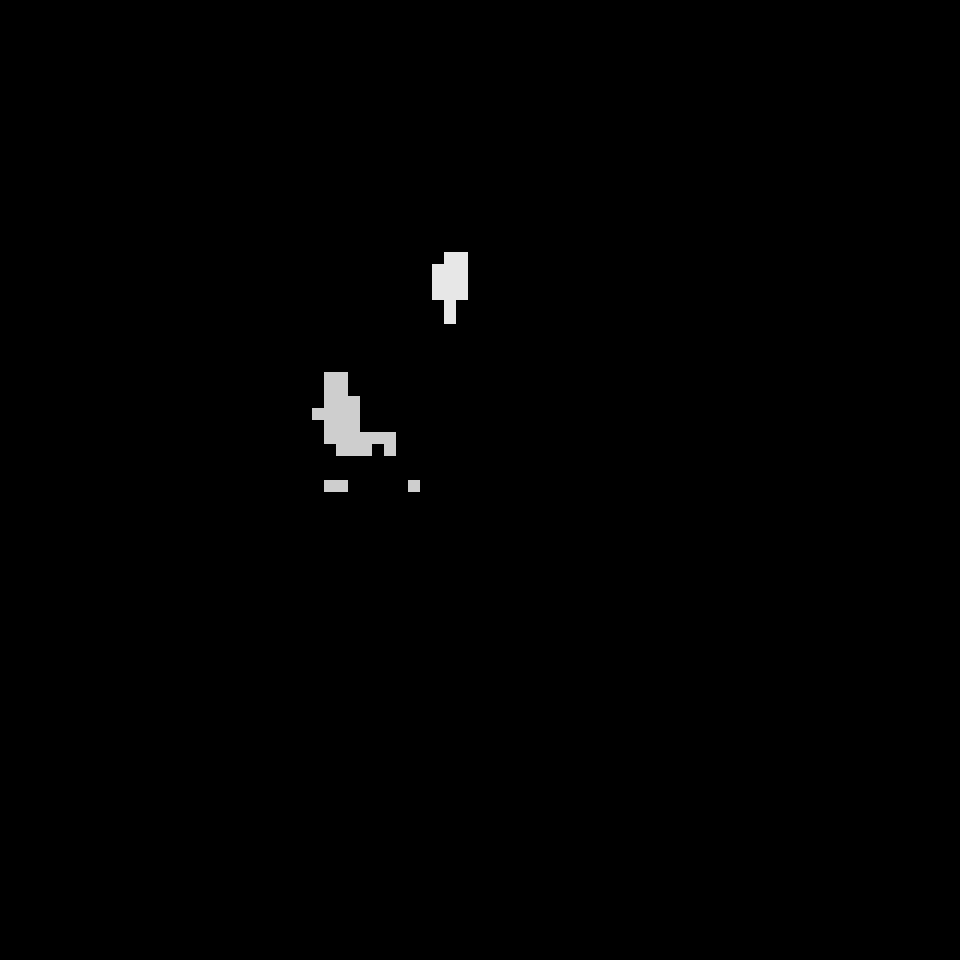

4


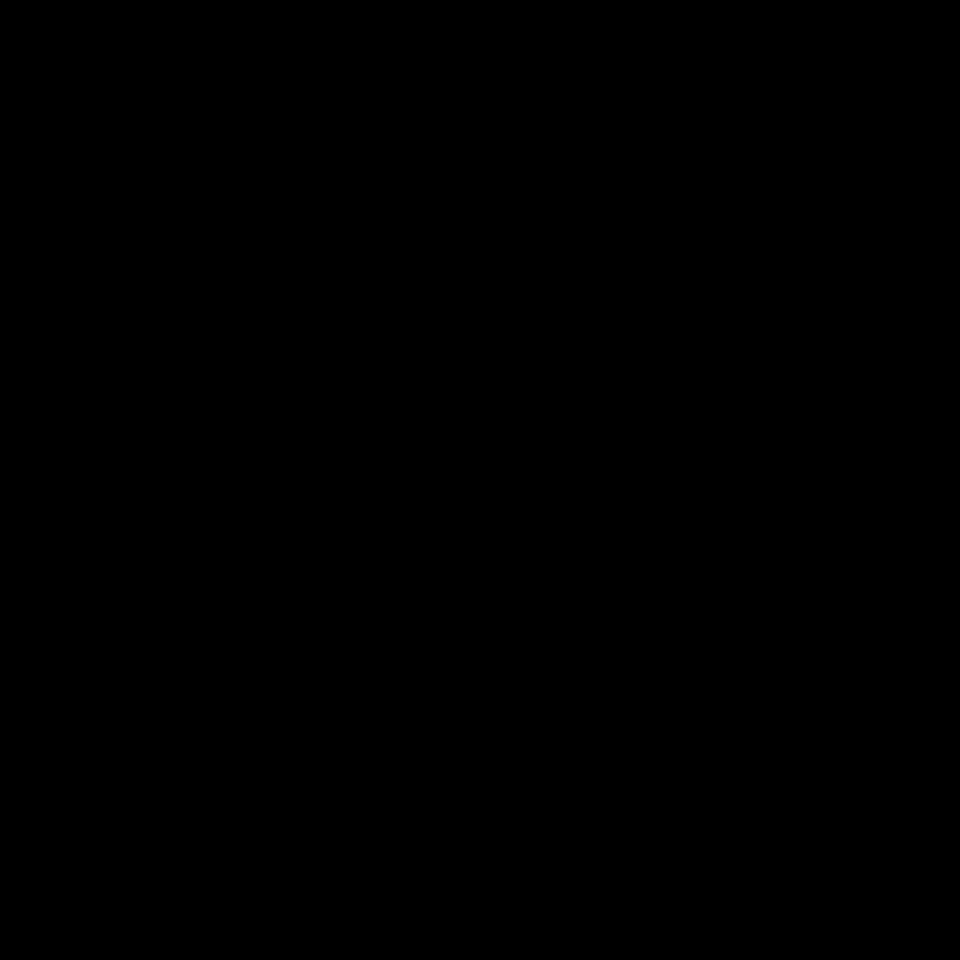

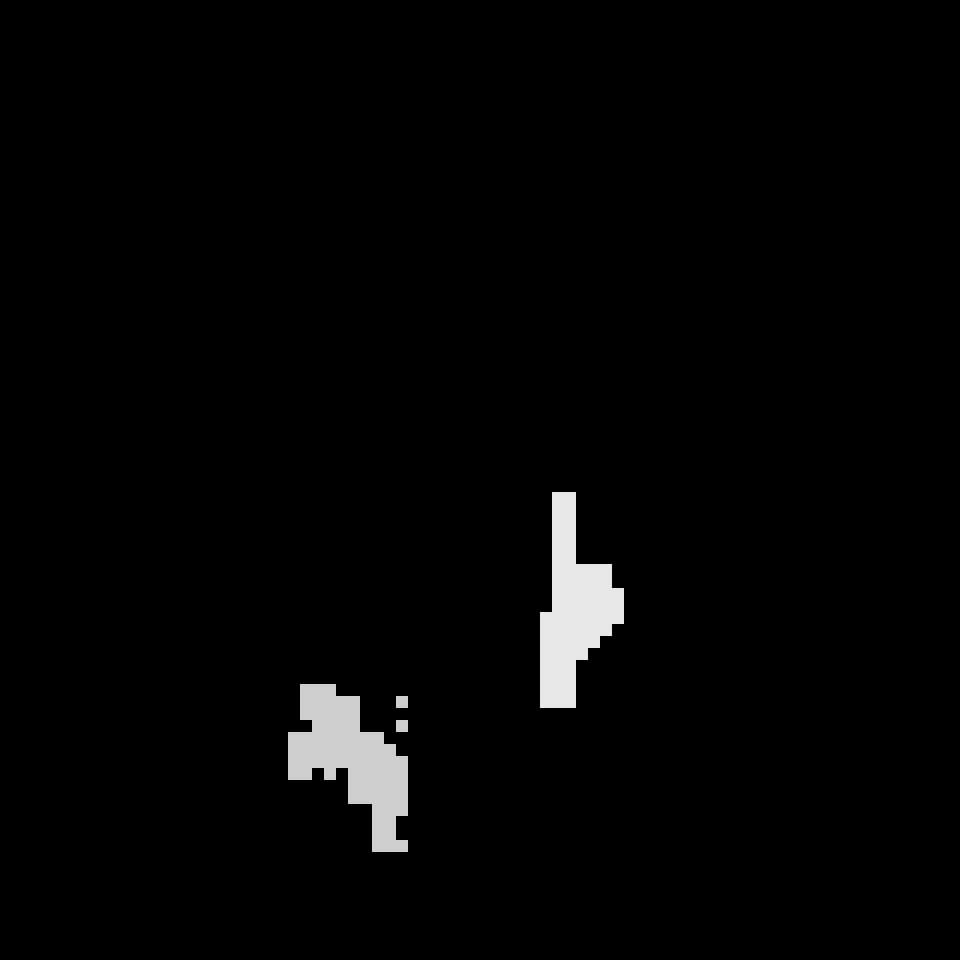

5


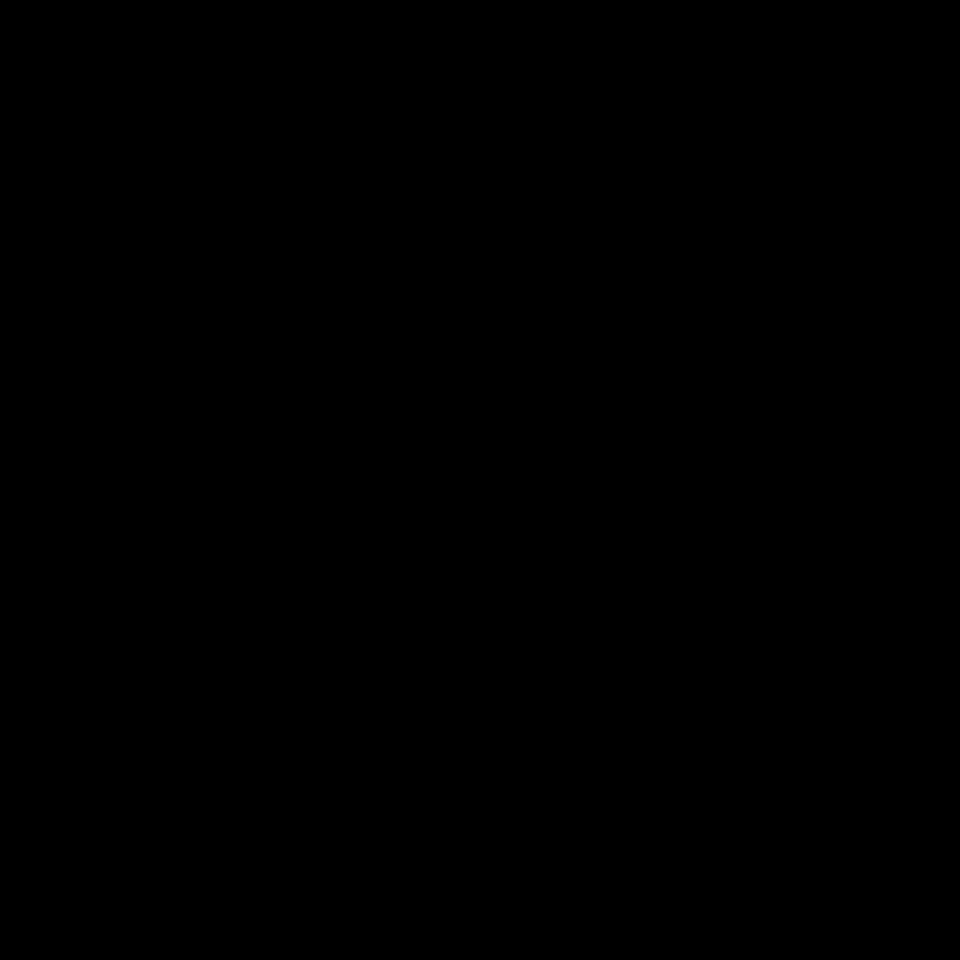

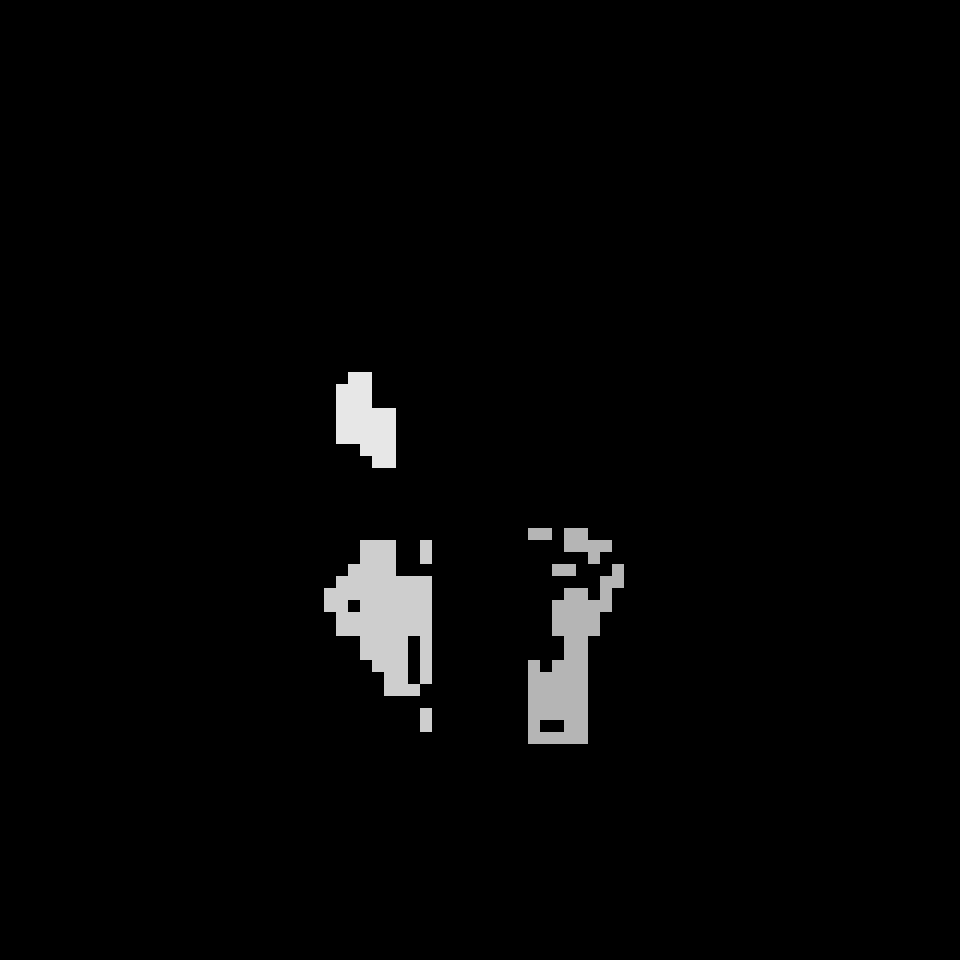

6


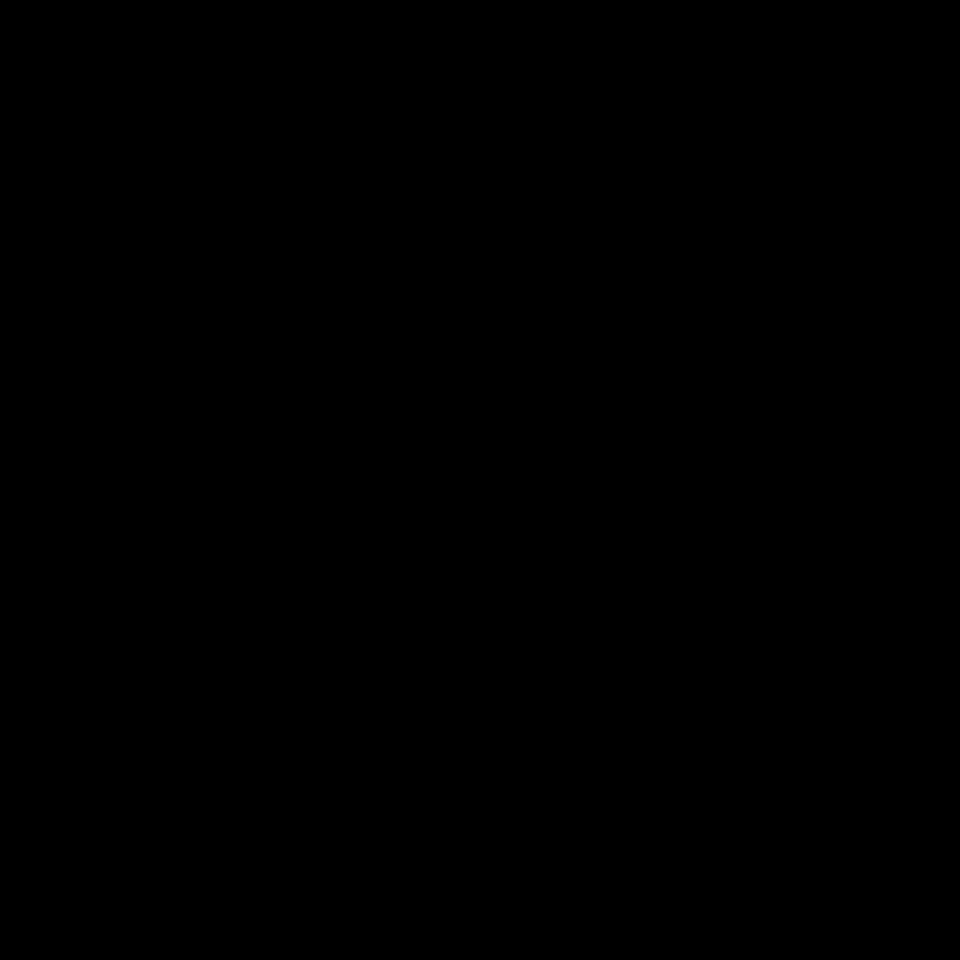

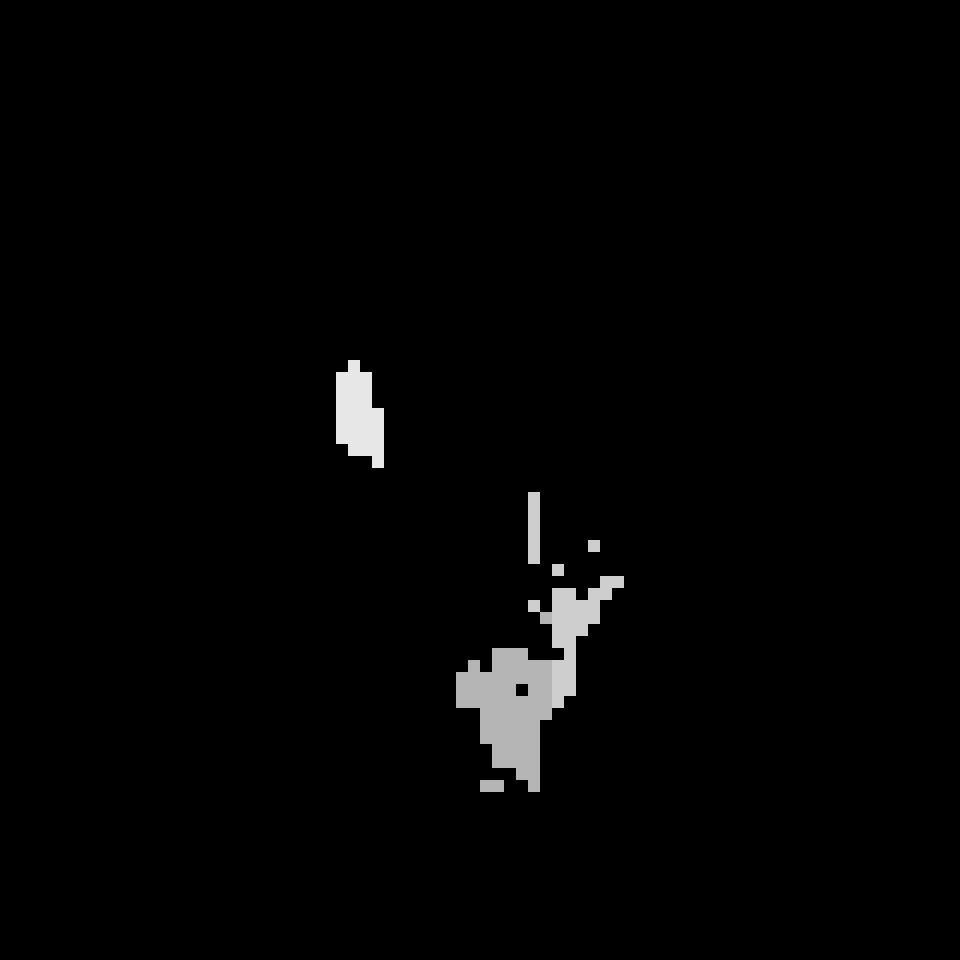

7


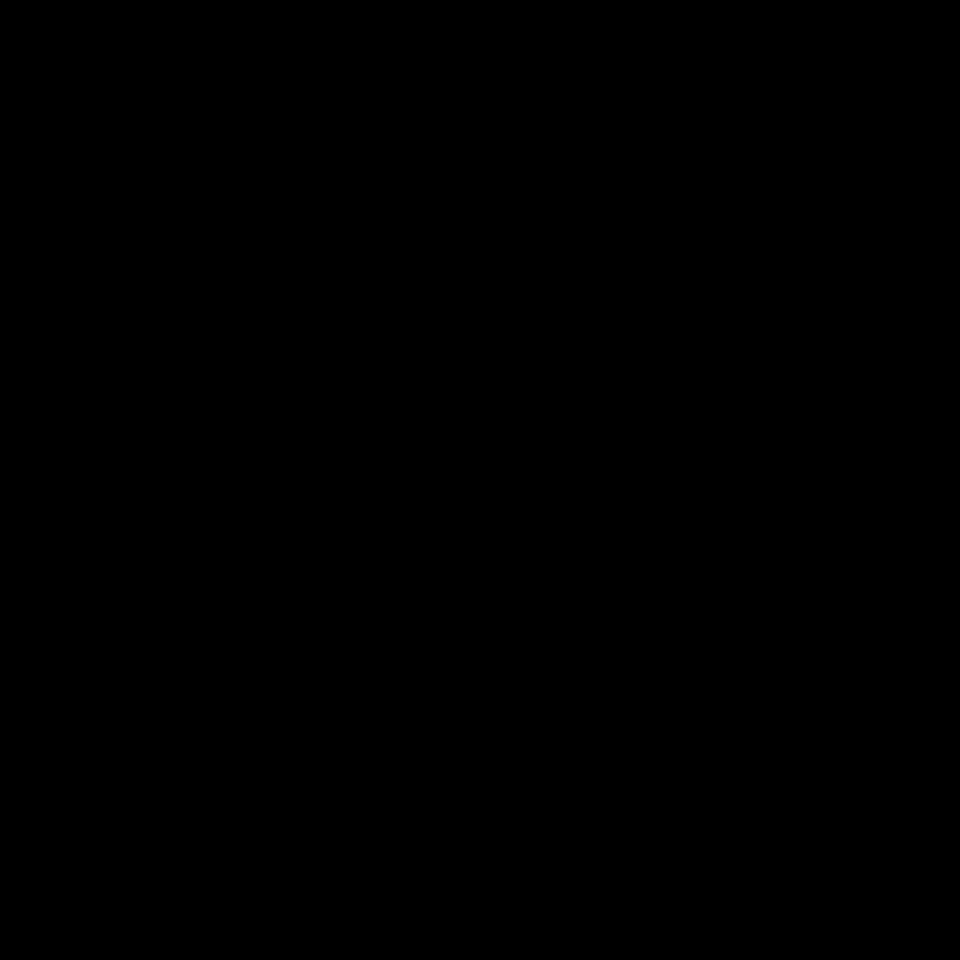

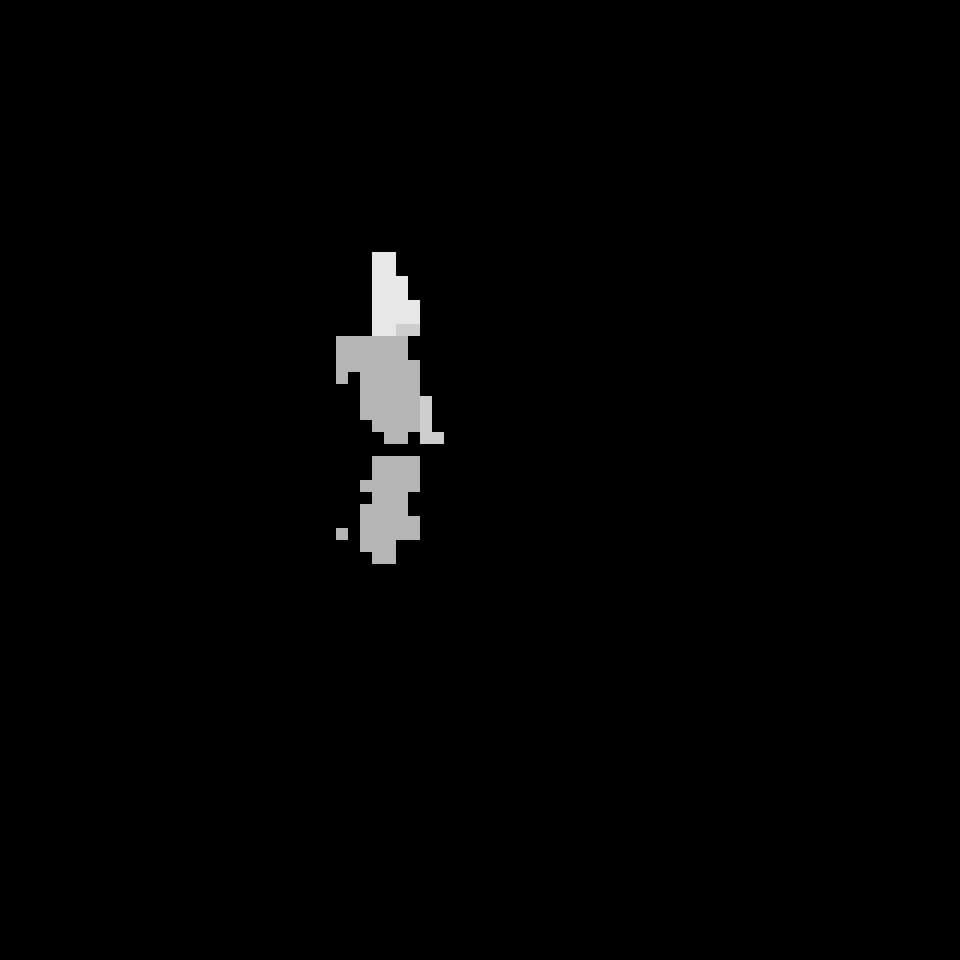

8


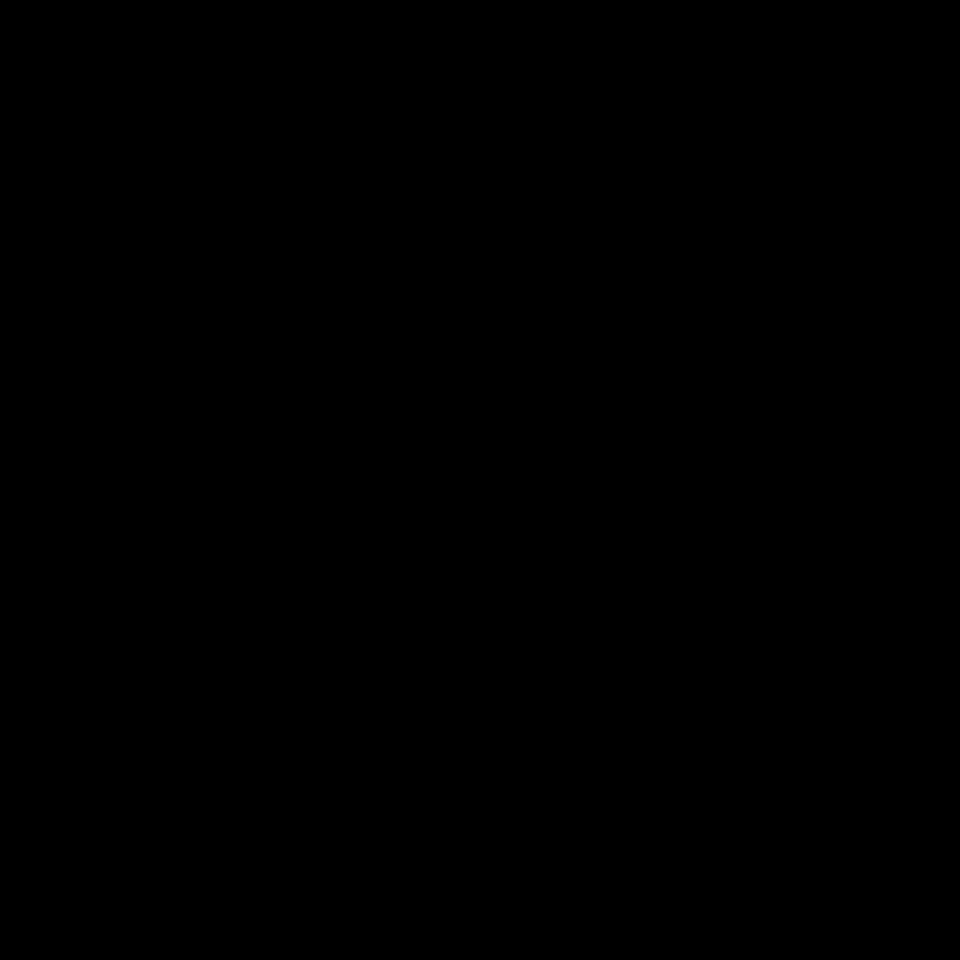

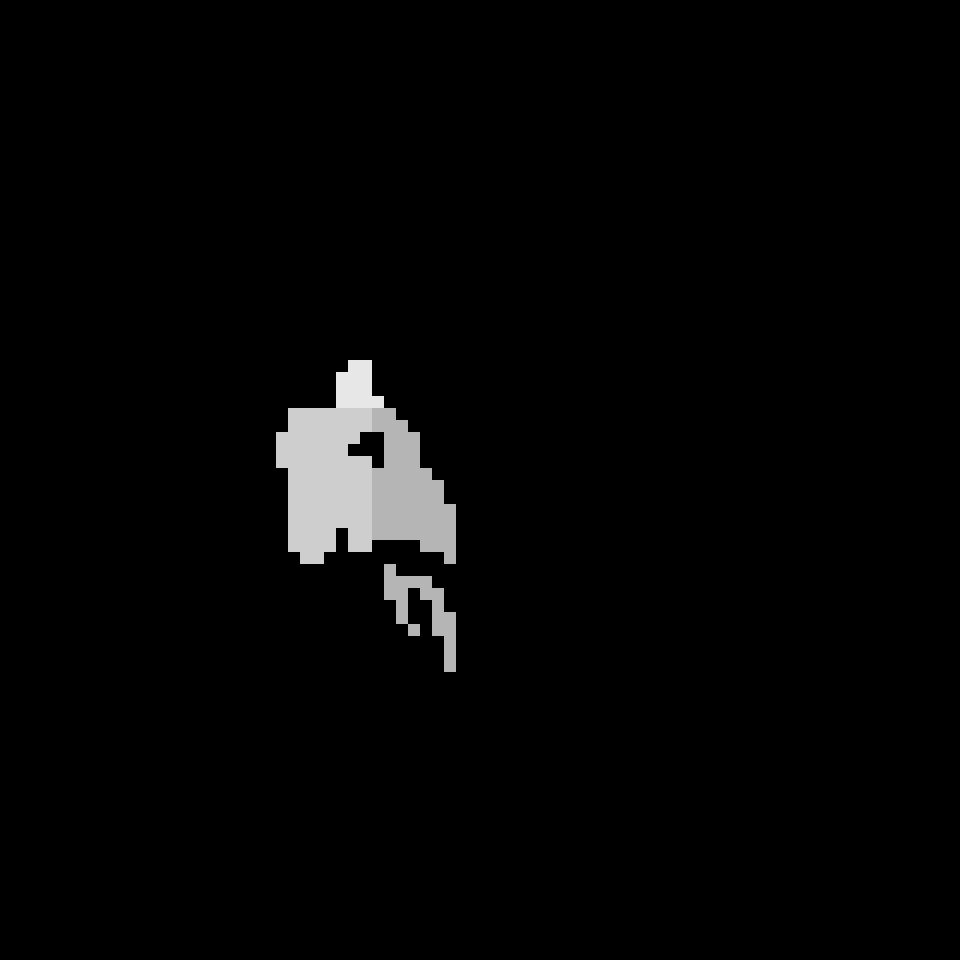

9


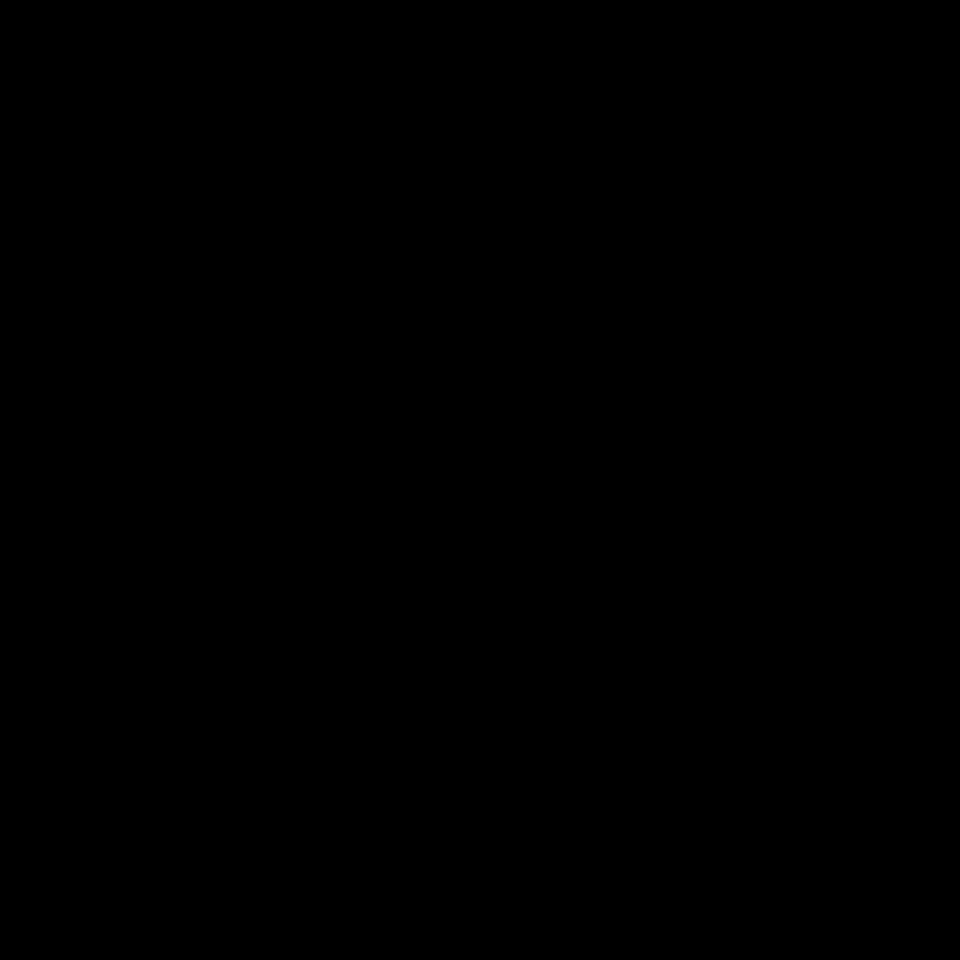

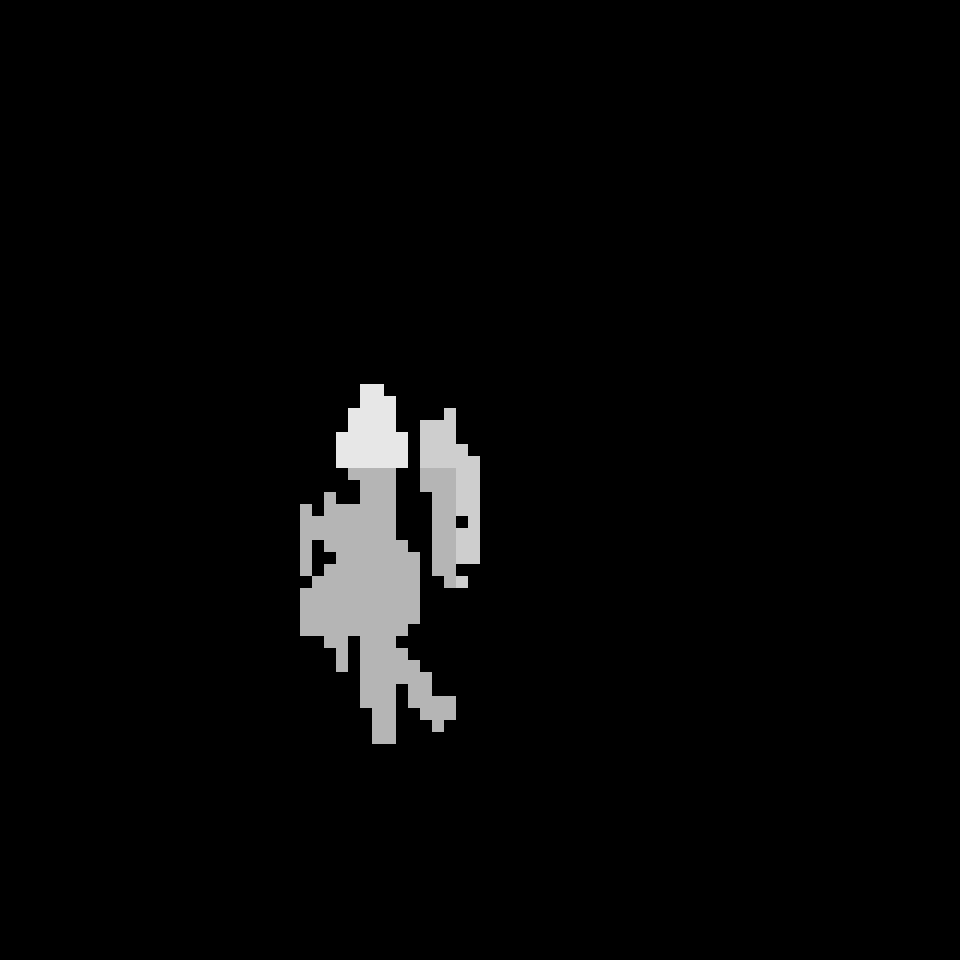

In [26]:
SIZE = 12
num = 9

predict_1 = predict_0 * (MAX-CLASS)
predict_1 = predict_1.astype(np.uint8)

Y2_1 = Y2_0 * (MAX-CLASS)
Y2_1 = Y2_1.astype(np.uint8)

for i in range(1, 10):
    print(i)
    predict_2 = cv2.resize(predict_1[i], (W*SIZE, H*SIZE), interpolation=cv2.INTER_NEAREST)
    img = Image.fromarray(predict_2)

    Y2_2 = cv2.resize(Y2_1[i], (W*SIZE, H*SIZE), interpolation=cv2.INTER_NEAREST)
    img1 = Image.fromarray(Y2_2)

    display(img)
    display(img1)


### 3.1 BIAS FINDER

In [27]:
n = len(predict_0)
F = 0
pp_li = []
for pp in np.arange(-0.0300, 0.1900, 0.01):
    predict1 = predict_0+pp
    for i in range(n):
        diff = abs(predict1[i].round(0).astype(int)-Y2_0[i])
        F += diff
    pp_li.append((pp,F))
    F = 0

for i in pp_li:
    print(i)

(-0.03, array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]]))
(-0.019999999999999997, array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        

### 3.2 ACCURACY

In [28]:
BIAS = 0.00
predict_1 = predict_0 + BIAS
n = len(predict)
wrong = 0
Y2_cnt = 0
# F_list = []
for i in range(n):
    Y2_cnt += Y2_0[i]
    diff = abs(predict_1[i].round(0).astype(int)-Y2_0[i])
    wrong += diff
    # F_list.append(diff[0])
print(f"error: {wrong}")
print(f"total: {Y2_cnt}")
print(f"acc:   {round((Y2_cnt-wrong)/Y2_cnt, 2)*100}%")


error: [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
total: [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


/tmp/ipykernel_53205/776224050.py:14: RuntimeWarning: invalid value encountered in true_divide
  print(f"acc:   {round((Y2_cnt-wrong)/Y2_cnt, 2)*100}%")


TypeError: type numpy.ndarray doesn't define __round__ method

### 3.3 VISUALIZE

In [ ]:
n = 20
for i in range(0, n, 1):
    # if Y2[i][0] > 0.3:
    diff = abs(predict_1[i].round(0).astype(int)-Y2_0[i])
    size = 10
    test_img = Image.fromarray((X2[i]*255).reshape(H,W)).convert('L').resize((W*size, H*size))
    print(f"pred: {predict_1[i]}")
    print(f"labl: {Y2_0[i]}")
    print(f"diff: {diff}")
    # print(f"diff: {X2[i]}")
    display(test_img)


In [ ]:
# BATCH = 32
# EPOCH = 30
#
# lb = Y2.reshape(-1)
# has = {}
#
# # np.array(list(set(Y2.reshape(-1)))).astype(np.int64)
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
# for ind in range(len(lb)):
#     # ind는 label 인덱스
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# x_data = []
# y_data = []
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(Y1[ind])
#         y_data.append(Y2[ind])
#
# x_data = np.array(x_data).astype(np.float32)
# y_data = np.array(y_data).astype(np.float32)
# X1 = X1.astype(np.float32)
# X2 = X2.astype(np.float32)
#
# for i in range(30):
#     print(i)
#     history = model.fit(X1, X2,
#                         # validation_split=0.2,
#                         validation_data=(x_data, y_data),
#                         batch_size=BATCH,
#                         epochs=EPOCH,
#                         verbose=1,
#                         # callbacks=[es],)
#                         # callbacks=[es, tensorboard_callback], )
#                         )
#     model.save('asdf/' + str(i) + '.h5')

In [ ]:
# epo = 10
# model = tf.keras.models.load_model('asdf/' + str(epo) + '.h5')
# Y2.shape
#
# lb = Y2.reshape(-1)
# has = {}
#
# # np.array(list(set(Y2.reshape(-1)))).astype(np.int64)
#
#
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
#
# for ind in range(len(lb)):
#
#     # ind는 label 인덱스
#
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# ls_num
#
# x_data = []
# y_data = []
#
#
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(Y1[ind])
#         y_data.append(Y2[ind])
#
# x_data = np.array(x_data)
# y_data = np.array(y_data)
# x_data.shape
# y_data.shape
#
#
# result = np.argmax(model.predict(x_data), -1)
# cont = 0
# for ind in range(len(result)):
#     if result[ind] == y_data.reshape(-1)[ind]:
#         cont +=1
#
#
# cont
# print(len(ls_num))
# print(cont/len(result))
